### Importamos librerías

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, make_scorer, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE, SMOTENC
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.externals.joblib import dump, load
import optuna
import os
from collections import Counter
import plotly.graph_objects as go

In [2]:
df = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'data','cerebrovascular.csv'))
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


### Análisis

In [3]:
Counter(df['stroke'])

Counter({0: 42617, 1: 783})

In [4]:
df.drop('id', axis=1, inplace=True)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
43395,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


In [6]:
df.drop(['hypertension', 'heart_disease', 'stroke'], axis=1).describe()

,age,avg_glucose_level,bmi
count,43400.000000,43400.000000,41938.000000
mean,42.217894,104.482750,28.605038
std,22.519649,43.111751,7.770020
min,0.080000,55.000000,10.100000
25%,24.000000,77.540000,23.200000
50%,44.000000,91.580000,27.700000
75%,60.000000,112.070000,32.900000
max,82.000000,291.050000,97.600000


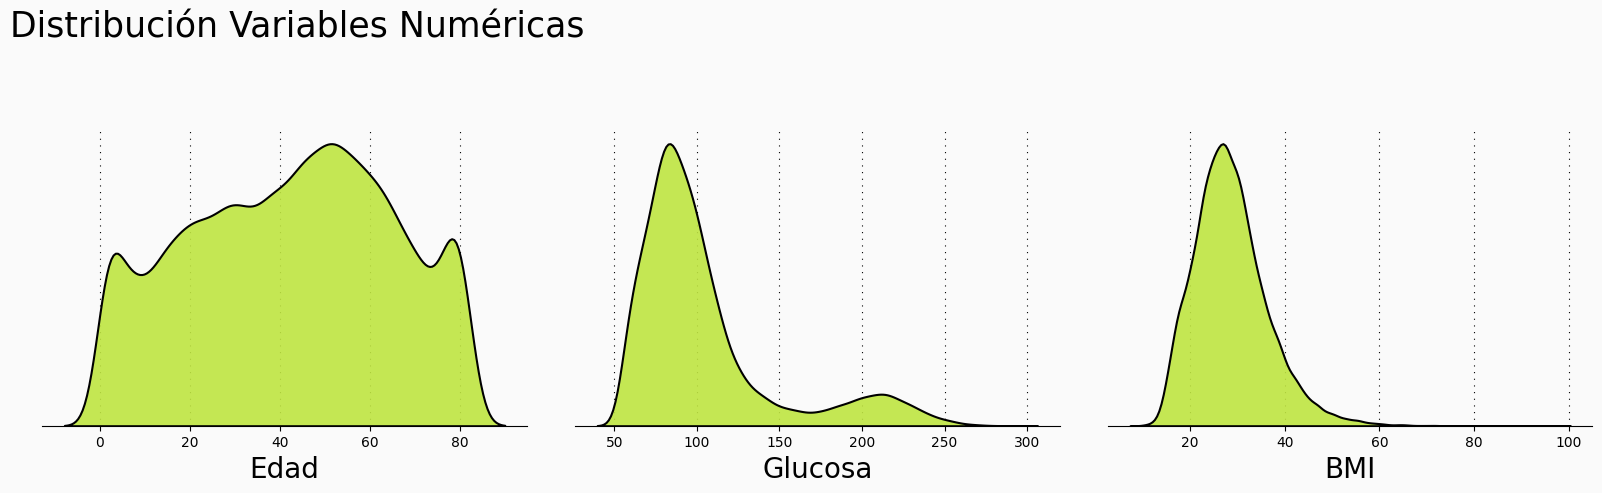

In [7]:
fig = plt.figure(figsize=(20, 20), facecolor='#fafafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)
conts = ['age','avg_glucose_level','bmi']
background_color = "#fafafa"

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in conts:
        sns.kdeplot(df[variable] ,ax=locals()["ax"+str(plot)], color='#bfe541', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='black', linestyle=':', dashes=(1,5))
        plot += 1
        
ax0.set_xlabel('Edad', fontsize=20)
ax1.set_xlabel('Glucosa', fontsize=20)
ax2.set_xlabel('BMI', fontsize=20)
ax0.text(-20, 0.022, 'Distribución Variables Numéricas', fontsize=25)

plt.show()
# fig.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', 'image', "var_ent.jpg"))

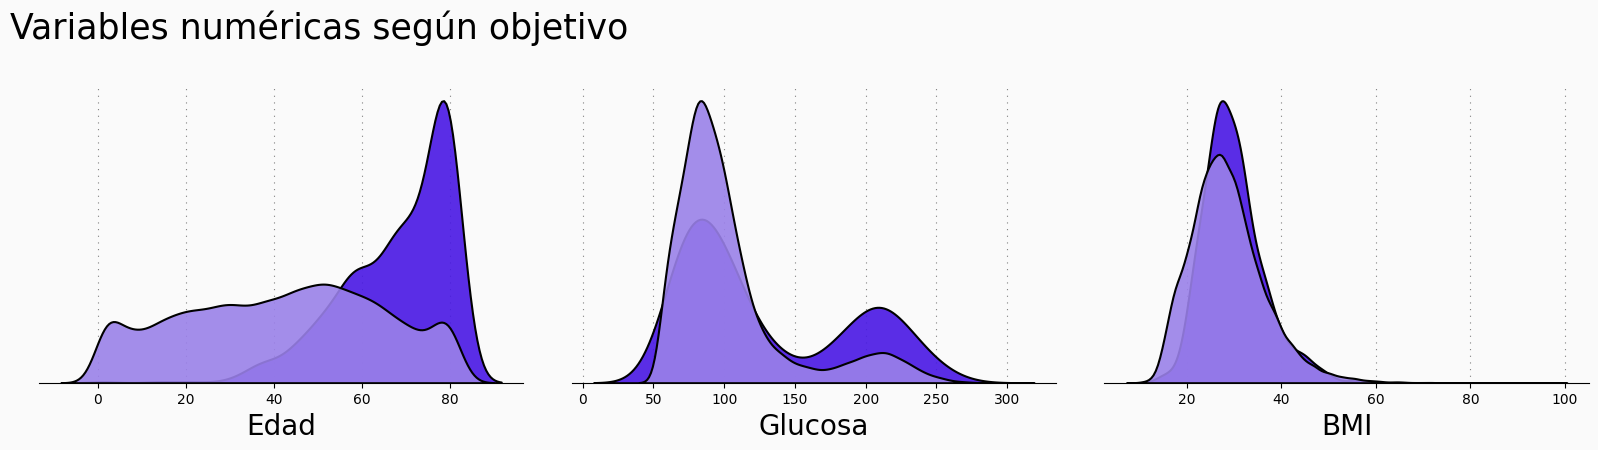

In [8]:
variables = [variable for variable in df.columns if variable not in ['id','stroke']]
conts = ['age','avg_glucose_level','bmi']
background_color = "#fafafa"

fig = plt.figure(figsize=(20, 20),facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#4817e4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9a81e9', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1

ax0.set_xlabel('Edad', fontsize=20)
ax1.set_xlabel('Glucosa', fontsize=20)
ax2.set_xlabel('BMI', fontsize=20)

ax0.text(-20, 0.056, 'Variables numéricas según objetivo', fontsize=25)

plt.show()
# fig.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "var_sep.jpg"))

In [9]:
columnas = ['age', 'avg_glucose_level', 'bmi']
nombres = ['Edad', 'Nivel de Glucosa', 'BMI']
colors = ['blue', 'green', 'red']

fig = go.Figure()
for num, i in enumerate(columnas):
    fig.add_trace(go.Box(y=df[i], name=nombres[num], marker_color=colors[num]))#, boxmean='sd', boxpoints='all', jitter=0.3, pointpos=-1.8, marker=dict(size=5, opacity=0.5), line=dict(width=2)))
    # fig.update_traces(marker=dict(color=colors[columnas.index(i)]))
fig.update_layout(title_text='Boxplot de variables numéricas', title_x=0.5, showlegend=False, title_font_color='black', width=1000, height=600)
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "boxplot.png"))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


In [11]:
gender = pd.value_counts(df['gender'])
gender

gender
Female    25665
Male      17724
Other        11
Name: count, dtype: int64

In [12]:
labels = ['Mujer', 'Hombre', 'Otro']
values = [25665, 17724, 11]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent+value', hole=.3, rotation=0)])
fig.update_layout(showlegend=False)
# fig.update_layout(legend=dict(orientation="v", xanchor="center", x=1, y=0.5)) # title_text='Distribución de Género', title_x=0.5, title_y=0.9, title_font=dict(size=25), 
fig.update_traces(textfont_size=12, pull=[0.1, 0.1], hoverinfo='label+percent+value')
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "gender.png"))

In [13]:
pd.DataFrame(df[['gender', 'stroke']].groupby('stroke').value_counts().unstack(fill_value=0))

gender,Female,Male,Other
stroke,,,
0,25234,17372,11
1,431,352,0


In [14]:
gender_df = pd.DataFrame(df[['gender', 'stroke']].groupby('stroke').value_counts(normalize=True).unstack(fill_value=0)).reset_index().replace({'stroke': {0: 'Negativo', 1: 'Positivo'}})
gender_df

gender,stroke,Female,Male,Other
0,Negativo,0.592111,0.407631,0.000258
1,Positivo,0.550447,0.449553,0.000000


In [15]:
fig = go.Figure(
    data=[
        
        go.Bar(x=gender_df.stroke, y=round(gender_df.Female*100,2), name="Mujer", text='Mujer', texttemplate="Mujer<br>%{y}%"),
        go.Bar(x=gender_df.stroke, y=round(gender_df.Male*100,2), name="Hombre", text='Hombre', texttemplate="Hombre<br>%{y}%"),
        go.Bar(x=gender_df.stroke, y=round(gender_df.Other*100,2), name="Otro", text='Otro', texttemplate="Otro<br>%{y}%"),
    ],
    layout=dict(
        barcornerradius=7,
        xaxis=dict(title='Ictus'),
        yaxis=dict(title='Género (%)'),
    ),
)
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=1.25, y=0.5)) # title_text='Distribución de Género', title_x=0.5, title_y=0.9, title_font=dict(size=25), 
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "bar_gender.png"))

In [16]:
pd.crosstab(index=df['stroke'], columns=df['gender'], margins=True).apply(lambda r: r/len(df) *100, axis=1)

gender,Female,Male,Other,All
stroke,,,,
0,58.142857,40.02765,0.025346,98.195853
1,0.993088,0.81106,0.000000,1.804147
All,59.135945,40.83871,0.025346,100.000000


In [17]:
hyper = pd.value_counts(df['hypertension'])
hyper

hypertension
0    39339
1     4061
Name: count, dtype: int64

In [18]:
labels = ['Negativo', 'Positivo']
values = [39339, 4061]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent+value', hole=.3, rotation=-90)])
fig.update_layout(showlegend=False)
fig.update_traces(textfont_size=12, pull=[0.1, 0.1], hoverinfo='label+percent+value')
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "hiper.png"))

In [19]:
hyper_df = pd.DataFrame(df[['hypertension', 'stroke']].groupby('stroke').value_counts(normalize=True).unstack(fill_value=0)).reset_index().replace(
    {'stroke': {0: 'Negativo', 1: 'Positivo'}}).rename(columns={'stroke': 'Ictus', 0: 'Negativo', 1: 'Positivo'})
hyper_df

hypertension,Ictus,Negativo,Positivo
0,Negativo,0.909402,0.090598
1,Positivo,0.744572,0.255428


In [20]:
fig = go.Figure(
    data=[
        go.Bar(x=hyper_df.Ictus, y=round(hyper_df.Negativo*100,2), name="Negativo", text='Negativo', texttemplate="Negativo<br>%{y}%"),
        go.Bar(x=hyper_df.Ictus, y=round(hyper_df.Positivo*100,2), name="Positivo", text='Positivo', texttemplate="Positivo<br>%{y}%"),
    ],
    layout=dict(
        barcornerradius=7,
        xaxis=dict(title='Ictus'),
        yaxis=dict(title='Hipertensión (%)'),
    ),
)
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=1.25, y=0.5))
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "bar_hyper.png"))

In [21]:
pd.crosstab(index=df['stroke'], columns=df['hypertension'], margins=True).apply(lambda r: r/len(df) *100, axis=1)

hypertension,0,1,All
stroke,,,
0,89.299539,8.896313,98.195853
1,1.343318,0.460829,1.804147
All,90.642857,9.357143,100.000000


In [22]:
heart = pd.value_counts(df['heart_disease'])
heart

heart_disease
0    41338
1     2062
Name: count, dtype: int64

In [23]:
labels = ['Negativo', 'Positivo']
values = [41338, 2062]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent+value', hole=.3, rotation=-90)])
fig.update_layout(showlegend=False)
fig.update_traces(textfont_size=12, pull=[0.1, 0.1], hoverinfo='label+percent+value')
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "cardio.png"))

In [24]:
heart_df = pd.DataFrame(df[['heart_disease', 'stroke']].groupby('stroke').value_counts(normalize=True).unstack(fill_value=0)).reset_index().replace(
    {'stroke': {0: 'Negativo', 1: 'Positivo'}}).rename(columns={'stroke': 'Ictus', 0: 'Negativo', 1: 'Positivo'})
heart_df

heart_disease,Ictus,Negativo,Positivo
0,Negativo,0.955769,0.044231
1,Positivo,0.773946,0.226054


In [25]:
fig = go.Figure(
    data=[
        go.Bar(x=heart_df.Ictus, y=round(heart_df.Negativo*100,2), name="Negativo", text='Negativo', texttemplate="Negativo<br>%{y}%"),
        go.Bar(x=heart_df.Ictus, y=round(heart_df.Positivo*100,2), name="Positivo", text='Positivo', texttemplate="Positivo<br>%{y}%"),
    ],
    layout=dict(
        barcornerradius=7,
        xaxis=dict(title='Ictus'),
        yaxis=dict(title='Cardiovascular (%)'),
    ),
)
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=1.25, y=0.5))
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "bar_cardio.png"))

In [26]:
pd.crosstab(index=df['stroke'], columns=df['heart_disease'], margins=True).apply(lambda r: r/len(df) *100, axis=1)

heart_disease,0,1,All
stroke,,,
0,93.852535,4.343318,98.195853
1,1.396313,0.407834,1.804147
All,95.248848,4.751152,100.000000


In [27]:
married = pd.value_counts(df['ever_married'])
married

ever_married
Yes    27938
No     15462
Name: count, dtype: int64

In [28]:
labels = ['Positivo', 'Negativo']
values = [27938, 15462]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent+value', hole=.3, rotation=0)])
fig.update_layout(showlegend=False) # title_text='Distribución de Género', title_x=0.5, title_y=0.9, title_font=dict(size=25), 
fig.update_traces(textfont_size=12, pull=[0.1, 0.1], hoverinfo='label+percent+value')
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "matr.png"))

In [29]:
married_df = pd.DataFrame(df[['ever_married', 'stroke']].groupby('stroke').value_counts(normalize=True).unstack(fill_value=0)).reset_index().replace(
    {'stroke': {0: 'Negativo', 1: 'Positivo'}}).rename(columns={'stroke': 'Ictus', 'No': 'Negativo', 'Yes': 'Positivo'})
married_df

ever_married,Ictus,Negativo,Positivo
0,Negativo,0.360936,0.639064
1,Positivo,0.102171,0.897829


In [30]:
fig = go.Figure(
    data=[
        
        go.Bar(x=married_df.Ictus, y=round(married_df.Positivo*100,2), name="Positivo", text='Positivo', texttemplate="Positivo<br>%{y}%"),
        go.Bar(x=married_df.Ictus, y=round(married_df.Negativo*100,2), name="Negativo", text='Negativo', texttemplate="Negativo<br>%{y}%"),
    ],
    layout=dict(
        barcornerradius=7,
        xaxis=dict(title='Ictus'),
        yaxis=dict(title='Matrimonio (%)'),
    ),
)
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=1.25, y=0.5))
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "bar_matrimonio.png"))

In [31]:
pd.crosstab(index=df['stroke'], columns=df['ever_married'], margins=True).apply(lambda r: r/len(df) *100, axis=1)

ever_married,No,Yes,All
stroke,,,
0,35.442396,62.753456,98.195853
1,0.184332,1.619816,1.804147
All,35.626728,64.373272,100.000000


In [32]:
work = pd.value_counts(df['work_type'])
work

work_type
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: count, dtype: int64

In [33]:
labels = ['Privado', 'Autónomo', 'Joven', 'Gobierno', 'Nunca']
values = [24834, 6793, 6156, 5440, 177]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent+value', hole=0.3, rotation=0)])
fig.update_layout(showlegend=False)
fig.update_traces(textfont_size=12, pull=[0.1, 0.1], hoverinfo='label+percent+value', insidetextorientation='horizontal')
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "work.png"))

In [34]:
work_df = pd.DataFrame(df[['work_type', 'stroke']].groupby('stroke').value_counts(normalize=True).unstack(fill_value=0)).reset_index().replace(
    {'stroke': {0: 'Negativo', 1: 'Positivo'}}).rename(columns={'stroke': 'Ictus', 'Govt_job': 'Gobierno', 'Never_worked': 'Nunca', 
                                                                'Private': 'Privado', 'Self-employed': 'Autónomo', 'children': 'Joven'})
work_df

work_type,Ictus,Gobierno,Nunca,Privado,Autónomo,Joven
0,Negativo,0.125560,0.004153,0.572377,0.153507,0.144402
1,Positivo,0.113665,0.000000,0.563218,0.320562,0.002554


In [35]:
fig = go.Figure(
    data=[
        
        go.Bar(x=work_df.Ictus, y=round(work_df.Privado*100,2), name="Privado", text='Privado', textposition='inside', textangle=0, texttemplate="Privado<br>%{y}%"),
        go.Bar(x=work_df.Ictus, y=round(work_df.Autónomo*100,2), name="Autónomo", text='Autónomo', textposition='inside', textangle=0, texttemplate="Autónomo<br>%{y}%"),
        go.Bar(x=work_df.Ictus, y=round(work_df.Joven*100,2), name="Joven", text='Joven', textangle=0, texttemplate="Joven<br>%{y}%"),
        go.Bar(x=work_df.Ictus, y=round(work_df.Gobierno*100,2), name="Gobierno", text='Gobierno', textposition='inside', textangle=0, texttemplate="Gobierno<br>%{y}%"),
        go.Bar(x=work_df.Ictus, y=round(work_df.Nunca*100,2), name="Nunca", text='Nunca', textposition='outside', textangle=0, texttemplate="Nunca<br>%{y}%"),
        
    ],
    layout=dict(
        barcornerradius=7,
        xaxis=dict(title='Ictus'),
        yaxis=dict(title='Trabajo (%)'),
    ),
)
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=1.25, y=0.5))
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "bar_work.png"))

In [36]:
pd.crosstab(index=df['stroke'], columns=df['work_type'], margins=True).apply(lambda r: r/len(df) *100, axis=1)

work_type,Govt_job,Never_worked,Private,Self-employed,children,All
stroke,,,,,,
0,12.329493,0.407834,56.205069,15.073733,14.179724,98.195853
1,0.205069,0.000000,1.016129,0.578341,0.004608,1.804147
All,12.534562,0.407834,57.221198,15.652074,14.184332,100.000000


In [37]:
residence = pd.value_counts(df['Residence_type'])
residence

Residence_type
Urban    21756
Rural    21644
Name: count, dtype: int64

In [38]:
labels = ['Urbano', 'Rural']
values = [21756, 21644]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent+value', hole=.3, rotation=180)])
fig.update_layout(showlegend=False) # title_text='Distribución de Género', title_x=0.5, title_y=0.9, title_font=dict(size=25), 
fig.update_traces(textfont_size=12, pull=[0.1, 0.1], hoverinfo='label+percent+value')
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "residencia.png"))

In [39]:
residence_df = pd.DataFrame(df[['Residence_type', 'stroke']].groupby('stroke').value_counts(normalize=True).unstack(fill_value=0)).reset_index().replace(
    {'stroke': {0: 'Negativo', 1: 'Positivo'}}).rename(columns={'stroke': 'Ictus', 'Govt_job': 'Gobierno', 'Never_worked': 'Nunca', 
                                                                'Private': 'Privado', 'Self-employed': 'Autónomo', 'children': 'Joven'})
residence_df

Residence_type,Ictus,Rural,Urban
0,Negativo,0.498862,0.501138
1,Positivo,0.490421,0.509579


In [40]:
fig = go.Figure(
    data=[
        
        go.Bar(x=residence_df.Ictus, y=round(residence_df.Urban*100,2), name="Urbano", text='Urbano', texttemplate="Urbano<br>%{y}%"),
        go.Bar(x=residence_df.Ictus, y=round(residence_df.Rural*100,2), name="Rural", text='Rural', texttemplate="Rural<br>%{y}%"),
    ],
    layout=dict(
        barcornerradius=7,
        xaxis=dict(title='Ictus'),
        yaxis=dict(title='Entorno (%)'),
    ),
)
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=1.25, y=0.5))
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "bar_residence.png"))

In [41]:
pd.crosstab(index=df['stroke'], columns=df['Residence_type'], margins=True).apply(lambda r: r/len(df) *100, axis=1)

Residence_type,Rural,Urban,All
stroke,,,
0,48.986175,49.209677,98.195853
1,0.884793,0.919355,1.804147
All,49.870968,50.129032,100.000000


In [42]:
smoke = pd.value_counts(df['smoking_status'].fillna('Unknown'))
smoke

smoking_status
never smoked       16053
Unknown            13292
formerly smoked     7493
smokes              6562
Name: count, dtype: int64

In [43]:
labels = ['Nunca', 'Desconocido', 'Pasado', 'Fumador']
values = [16053, 13292, 7493, 6562]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent+value', hole=.3, rotation=0)])
fig.update_layout(showlegend=False) 
fig.update_traces(textfont_size=12, pull=[0.1, 0.1], hoverinfo='label+percent+value', insidetextorientation='horizontal', textposition='inside')
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "tabaco.png"))

In [44]:
smoke_df = pd.DataFrame(df[['smoking_status', 'stroke']].fillna('Unknown').groupby('stroke').value_counts(normalize=True).unstack(fill_value=0)).reset_index().replace(
    {'stroke': {0: 'Negativo', 1: 'Positivo'}}).rename(columns={'stroke': 'Ictus', 'formerly smoked': 'Pasado', 'never smoked': 'Nunca', 
                                                                'smokes': 'Fumador', 'Unknown': 'Desconocido'})
smoke_df

smoking_status,Ictus,Desconocido,Pasado,Nunca,Fumador
0,Negativo,0.308492,0.170636,0.370017,0.150855
1,Positivo,0.185185,0.282248,0.362708,0.169860


In [45]:
fig = go.Figure(
    data=[
        go.Bar(x=smoke_df.Ictus, y=round(smoke_df.Nunca*100,2), name="Nunca", text='Nunca', textposition='inside', textangle=0, texttemplate="Nunca<br>%{y}%"),
        go.Bar(x=smoke_df.Ictus, y=round(smoke_df.Desconocido*100,2), name="Desconocido", text='Desconocido', textposition='inside', textangle=0, texttemplate="Desconocido<br>%{y}%"),
        
        go.Bar(x=smoke_df.Ictus, y=round(smoke_df.Pasado*100,2), name="Pasado", text='Pasado', textposition='inside', textangle=0, texttemplate="Pasado<br>%{y}%"),
        go.Bar(x=smoke_df.Ictus, y=round(smoke_df.Fumador*100,2), name="Fumador", text='Fumador', textposition='inside', textangle=0, texttemplate="Fumador<br>%{y}%"),
    ],
    layout=dict(
        barcornerradius=7,
        xaxis=dict(title='Ictus'),
        yaxis=dict(title='Tabaquismo (%)'),
    ),
)
fig.update_layout(legend=dict(orientation="v", xanchor="center", x=1.25, y=0.5))
fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "bar_smoke.png"))

In [46]:
pd.crosstab(index=df['stroke'], columns=df['smoking_status'].fillna('Unknown'), margins=True).apply(lambda r: r/len(df) *100, axis=1)

smoking_status,Unknown,formerly smoked,never smoked,smokes,All
stroke,,,,,
0,30.292627,16.755760,36.334101,14.813364,98.195853
1,0.334101,0.509217,0.654378,0.306452,1.804147
All,30.626728,17.264977,36.988479,15.119816,100.000000


### Procesamiento

In [47]:
# mean_age = np.mean(df['age'])
# std_dev_age = np.std(df['age'])

# # More than 3 standard deviations from the mean an outlier
# threshold = 3

# #create the condition to find outliers
# outliers_age = df['age'][np.abs(df['age'] - mean_age) > threshold * std_dev_age]
# print(outliers_age)

In [48]:
# mean_glucose = np.mean(df['avg_glucose_level'])
# std_dev_glucose = np.std(df['avg_glucose_level'])

# # More than 3 standard deviations from the mean an outlier
# threshold = 3

# # Create the condition to find outliers
# outliers_glucose = df['avg_glucose_level'][np.abs(df['avg_glucose_level'] - mean_glucose) > threshold * std_dev_glucose]
# print(outliers_glucose)

# # Delete outliers from dataset
# df.drop(outliers_glucose.index, inplace = True)

In [49]:
# condition = df[(df['bmi'] > 60)].index
# df.drop(condition, inplace=True)

### Transformación

In [51]:
df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(int)
df['ever_married'] = df['ever_married'].replace({'No':0,'Yes':1}).astype(int)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(int)
df['smoking_status'] = df['smoking_status'].fillna('Unknown')
# cond1 = df['smoking_status'] == 'Unknown'
# cond2 = df['smoking_status'] == 'formerly smoked'
# cond3 = df['smoking_status'] == 'never smoked'
# cond4 = df['smoking_status'] == 'smokes'
# df['smoking_status'] = np.where(cond1, -1, np.where(cond3, 0, np.where(cond4, 1, np.where(cond2, 2, -1))))
# cond1 = df['work_type'] == 'children'
# cond2 = df['work_type'] == 'Govt_job'
# cond3 = df['work_type'] == 'Private'
# cond4 = df['work_type'] == 'Self-employed'
# cond5 = df['work_type'] == 'Never_worked'
# df['work_type'] = np.where(cond5, 0, np.where(cond1, 1, np.where(cond2, 2, np.where(cond3, 3, np.where(cond4, 4, -1)))))

In [52]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']
binary_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
categorical_features = ['work_type', 'smoking_status']
target = 'stroke'

X_cat_features = df[categorical_features]
print("Categorical features: ", list(X_cat_features.columns)) # + co_loader_columns)

# oHec = OneHotEncoder()
# X_enc = oHec.fit_transform(X_cat_features)
# X_cat_features = pd.DataFrame(X_enc.toarray(), columns=oHec.get_feature_names_out())

print("Numerical features: ", numerical_features)
scaler = StandardScaler()
X_num_features = scaler.fit_transform(df[numerical_features])
X_num_features = pd.DataFrame(X_num_features, columns=numerical_features)

X_bin_features = df[binary_features]
    
X = pd.concat([X_num_features.reset_index(drop=True), X_bin_features.reset_index(drop=True), X_cat_features.reset_index(drop=True)], axis=1)     
y = df[target]     
print("Target (dependent) variable: ", target)

Categorical features:  ['work_type', 'smoking_status']
Numerical features:  ['age', 'avg_glucose_level', 'bmi']
Target (dependent) variable:  stroke


In [54]:
X.isnull().sum()

age                     0
avg_glucose_level       0
bmi                  1462
gender                  0
hypertension            0
heart_disease           0
ever_married            0
Residence_type          0
work_type               0
smoking_status          0
dtype: int64

Imputamos valores nulos

In [55]:
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X[numerical_features])
X_imputed = pd.DataFrame(X_imputed, columns=numerical_features)
X = pd.concat([X_imputed.reset_index(drop=True), X[binary_features].reset_index(drop=True), X[categorical_features].reset_index(drop=True)], axis=1) 
X.isnull().sum()

age                  0
avg_glucose_level    0
bmi                  0
gender               0
hypertension         0
heart_disease        0
ever_married         0
Residence_type       0
work_type            0
smoking_status       0
dtype: int64

#### SMOTE NC

Aplicamos SMOTE NC antes de transformar los categóricos con OneHotEncoder

In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                43400 non-null  float64
 1   avg_glucose_level  43400 non-null  float64
 2   bmi                43400 non-null  float64
 3   gender             43400 non-null  int64  
 4   hypertension       43400 non-null  int64  
 5   heart_disease      43400 non-null  int64  
 6   ever_married       43400 non-null  int64  
 7   Residence_type     43400 non-null  int64  
 8   work_type          43400 non-null  object 
 9   smoking_status     43400 non-null  object 
dtypes: float64(3), int64(5), object(2)
memory usage: 3.3+ MB


Dividimos entre train y test equilibrando ambos según variable objetivo

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
# def objective(trial):

#     sampling_strategy = trial.suggest_float('sampling_strategy', 0.1, 1.0, step=0.1)
#     k_neighbors = trial.suggest_int('k_neighbors', 1, 9, step=1)

#     smote = SMOTENC(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, categorical_features=[8, 9], random_state=42)

#     X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#     # OneHotEncoder
#     X_train_res_cat = X_train_res.iloc[:, 8:10]
#     X_test_cat = X_test.iloc[:, 8:10]
#     X_train_res_num = X_train_res.iloc[:, 0:8]
#     X_test_num = X_test.iloc[:, 0:8]
#     oHec = OneHotEncoder(drop='first')
#     X_train_res_cat = oHec.fit_transform(X_train_res_cat)
#     X_test_enc_cat = oHec.transform(X_test_cat)
#     X_train_res_cat = pd.DataFrame(X_train_res_cat.toarray(), columns=oHec.get_feature_names_out())
#     X_test_enc_cat = pd.DataFrame(X_test_enc_cat.toarray(), columns=oHec.get_feature_names_out())
#     X_train_res = pd.concat([X_train_res_num.reset_index(drop=True), X_train_res_cat.reset_index(drop=True)], axis=1)
#     X_test_enc = pd.concat([X_test_num.reset_index(drop=True), X_test_enc_cat.reset_index(drop=True)], axis=1)

#     model = RandomForestClassifier()
#     model.fit(X_train_res, y_train_res)

#     y_pred = np.round(model.predict(X_test_enc))

#     precision = precision_score(y_test,y_pred)
#     recall = recall_score(y_test,y_pred)
#     f1 = f1_score(y_test,y_pred)
#     roc = roc_auc_score(y_test,y_pred)

#     trial.set_user_attr('precision', precision)
#     trial.set_user_attr('recall', recall)
#     trial.set_user_attr('f1', f1)
   
#     return roc

# study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
# study.optimize(objective, n_jobs=-1, n_trials=100)

In [60]:
X_train.reset_index(drop=True, inplace=True), X_test.reset_index(drop=True, inplace=True), y_train.reset_index(drop=True, inplace=True), y_test.reset_index(drop=True, inplace=True)
len(X_train), len(X_test), len(y_train), len(y_test)

(34720, 8680, 34720, 8680)

In [ ]:
# smote_params = study.best_params
smote_params = {'k_neighbors': 9, 'sampling_strategy': 1.0, 'categorical_features': [8, 9], 'random_state': 0}
smote = SMOTENC(**smote_params)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# X_test_res, y_test_res = smote.fit_resample(X_test, y_test)

X_train_res_cat = X_train_res.iloc[:, 8:10]
X_test_cat = X_test.iloc[:, 8:10]
X_train_res_num = X_train_res.iloc[:, 0:8]
X_test_num = X_test.iloc[:, 0:8]

oHec = OneHotEncoder(drop='first')
X_train_res_cat = oHec.fit_transform(X_train_res_cat)
X_test_cat = oHec.transform(X_test_cat)
X_train_res_cat = pd.DataFrame(X_train_res_cat.toarray(), columns=oHec.get_feature_names_out())
X_test_cat = pd.DataFrame(X_test_cat.toarray(), columns=oHec.get_feature_names_out())
X_train_res = pd.concat([X_train_res_num.reset_index(drop=True), X_train_res_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)
y_train_res = pd.DataFrame(y_train_res, columns=['stroke'])

X_train_smote, y_train_smote = X_train_res[len(X_train):], y_train_res[len(y_train):]
synthetic_rows = list(X_train_smote.index)

Guardamos objetos de OneHotEncoder y StandardScaler

In [64]:
with open(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'data', 'scaler'), 'wb') as f: 
    pickle.dump(scaler, f)

with open(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'data', 'encoder'), 'wb') as f: 
    pickle.dump(oHec, f)

### Selección de características (No integrado)

Wrapper

In [65]:
# model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
# rfe = RFE(estimator=model_tree)
# rfe_model = rfe.fit(X, y)
# print("Número de características seleccionadas: ", rfe_model.n_features_)
# print("Atributos seleccionados: ", rfe_model.support_)
# print("Ranking de características: ", rfe_model.ranking_)

In [66]:
# imp_features = np.sort(rfe.get_support(1))

In [67]:
# X = X[X.columns[imp_features]]

### Modelos de clasificación

In [70]:
models = []
models.extend([
        ['XGBClassifier',XGBClassifier()],
        ['Logistic Regression',LogisticRegression()],
        ['SVC',SVC(probability=True)],
        ['KNeigbors',KNeighborsClassifier()],
        ['RandomForest',RandomForestClassifier()],
        ['AdaBoostClassifier',AdaBoostClassifier()]])

In [ ]:
lst_1 = []
for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    print("Training model: ", models[m][0])
    model.fit(X_train_res,y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    roc = roc_auc_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
    auc_precision_recall = auc(recalls, precisions)
    ap = average_precision_score(y_test, y_prob)
    f1 = f1_score(y_test,y_pred)

    lst_2.append(models[m][0])
    lst_2.append(balanced_accuracy_score(y_test,y_pred)*100)
    lst_2.append(accuracy_score(y_test,y_pred)*100)
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(auc_precision_recall)
    lst_2.append(ap)
    lst_2.append(f1)
    lst_1.append(lst_2)

Training model:  XGBClassifier
Training model:  Logistic Regression
Training model:  SVC
Training model:  KNeigbors
Training model:  RandomForest
Training model:  AdaBoostClassifier


In [ ]:
# df2 = pd.DataFrame(lst_1, columns=['Model','Balanced Accuracy','Accuracy','ROC_AUC','Precision','Recall','Precision recall AUC', 'Average precision', 'F1 Score'])
# df2.sort_values(by='Average precision', inplace=True, ascending=False)
# df2.to_csv(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))),'data', 'comparaciones.csv'), index=False)
df2 = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))),'data', 'comparaciones.csv'))
df2

,Model,Balanced Accuracy,Accuracy,ROC_AUC,Precision,Recall,Precision recall AUC,Average precision,F1 Score
0,Logistic Regression,74.003726,75.345622,0.740037,0.051560,0.726115,0.077412,0.079544,0.096284
1,AdaBoostClassifier,74.297087,71.624424,0.742971,0.047488,0.770701,0.083005,0.065291,0.089464
2,SVC,66.987268,78.755760,0.669873,0.046261,0.547771,0.045491,0.046639,0.085317
3,RandomForest,55.856577,91.889401,0.558566,0.047934,0.184713,0.044883,0.045274,0.076115
4,XGBClassifier,56.071955,92.926267,0.560720,0.054581,0.178344,0.042481,0.043629,0.083582
5,KNeigbors,61.152475,85.714286,0.611525,0.046862,0.356688,0.103003,0.034223,0.082840


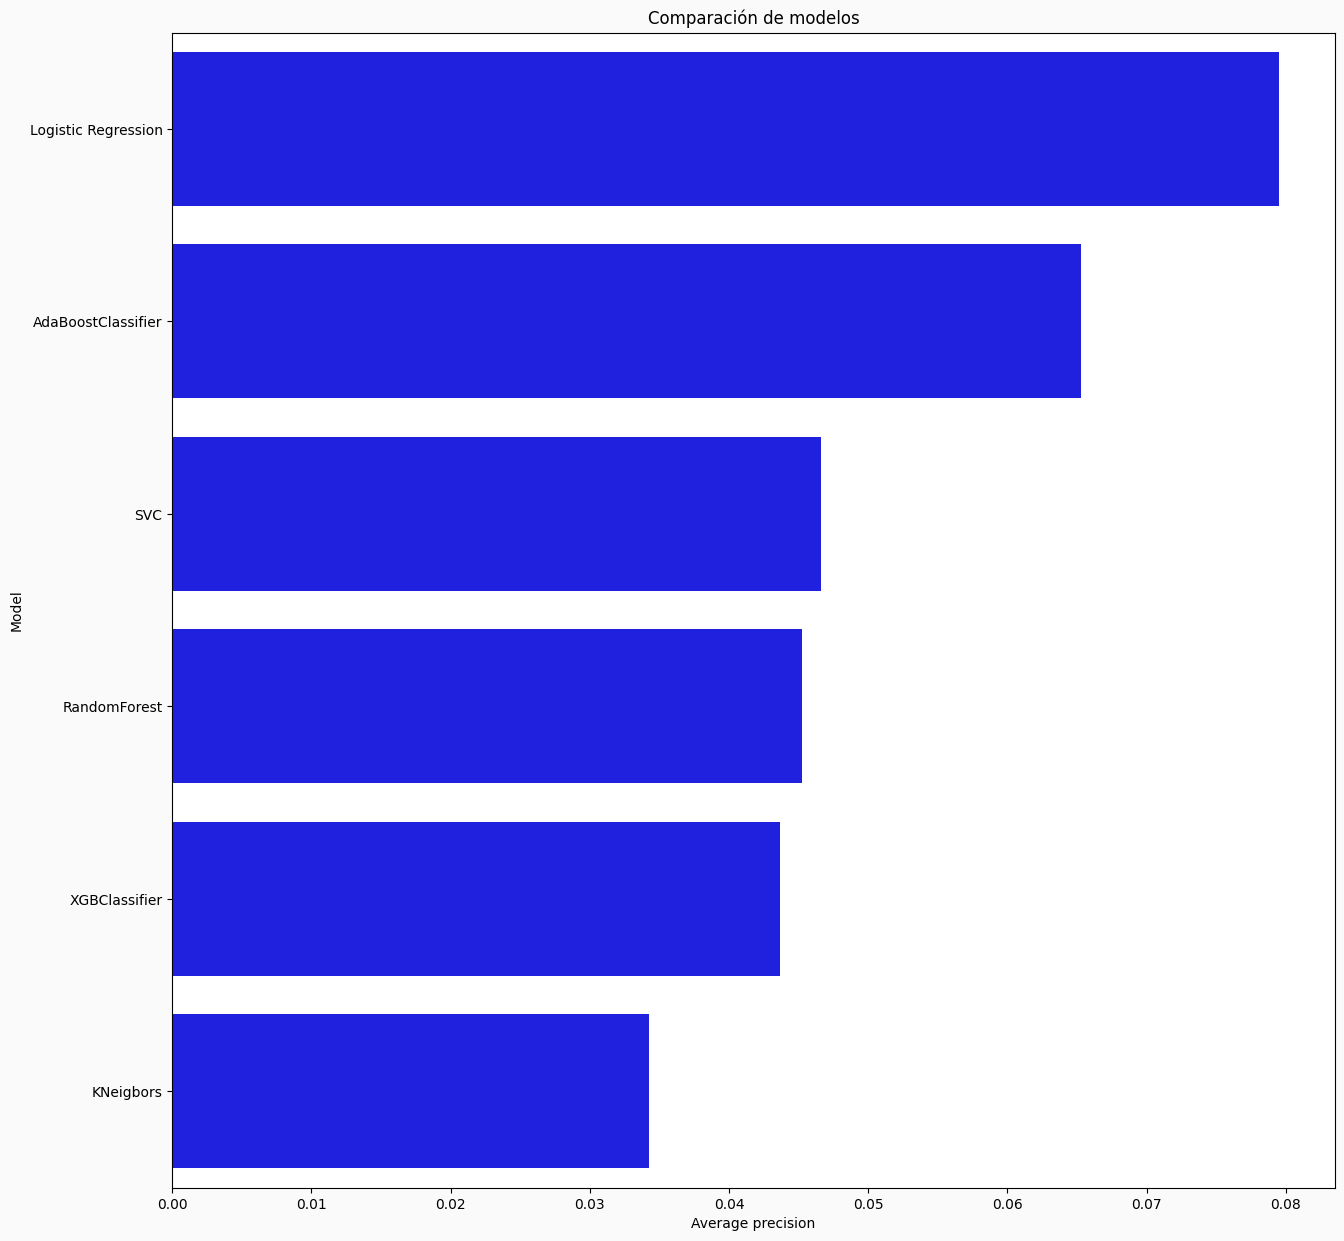

In [75]:
fig = plt.figure(figsize=(15, 15), facecolor=background_color)
sns.barplot(x='Average precision', y='Model', data=df2, color='b')
plt.title('Comparación de modelos');
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))),'utils', "image", "comp.jpg"))

In [93]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df2['Average precision'],
    y=df2['Model'],
    orientation='h',
    marker=dict(color='blue'),
))
fig.update_layout(
    title='Comparación de modelos según AUC PR',
    xaxis_title='Precisión media',
    #axis_title='Modelo',
    title_x=0.5,
    width=1000,
    height=600,
    # template='plotly_white'
)
# Axis text color black
fig.update_xaxes(title_font_color='black', tickfont_color='black')

fig.show()
fig.write_image(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "comp_plotly.jpg"))

-- --

### Optuna

Set validacion, CV programado, precision-recall, smote en train solo

In [51]:
def custom_cross_val(model, X, y, synthetic_rows, cv=3):

    sss = StratifiedShuffleSplit(n_splits=cv, test_size=0.2, random_state=42)
    scores = []
    
    for train_index, val_index in sss.split(X, y):

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_val = X_val[~X_val.index.isin(synthetic_rows)]
        y_val = y_val[~y_val.index.isin(synthetic_rows)]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_val)[:, 1]

        # precision, recall, thresholds = precision_recall_curve(y_val, y_prob)
        # auc_precision_recall = auc(recall, precision)
        ap = average_precision_score(y_val, y_prob)
        scores.append(ap)
        
    return np.mean(scores), np.std(scores)

-- --

Logistic Regression

In [57]:
def objective(trial):

    params = {
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-2, 1)
    }   
    model = LogisticRegression(**params)
    mean, std = custom_cross_val(model, X_train_res, y_train_res, synthetic_rows, cv=3)

    trial.set_user_attr('Standard deviation', std)
   
    return mean

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=200)

[I 2025-04-18 15:21:59,601] A new study created in memory with name: no-name-dcc4ee80-965d-4a43-8d63-6df38b3992a9
[I 2025-04-18 15:22:04,361] Trial 0 finished with value: 0.08166047778513726 and parameters: {'tol': 5.9933815430419616e-05, 'C': 0.43177789284716406}. Best is trial 0 with value: 0.08166047778513726.
[I 2025-04-18 15:22:05,836] Trial 1 finished with value: 0.08225087726586046 and parameters: {'tol': 0.0008964107435128648, 'C': 0.015473376191450963}. Best is trial 1 with value: 0.08225087726586046.
[I 2025-04-18 15:22:07,461] Trial 2 finished with value: 0.08159274259188565 and parameters: {'tol': 0.00010301387935287525, 'C': 0.9897046325142552}. Best is trial 1 with value: 0.08225087726586046.
[I 2025-04-18 15:22:08,634] Trial 3 finished with value: 0.08193453753690835 and parameters: {'tol': 0.0008763982452774168, 'C': 0.13061722206231696}. Best is trial 1 with value: 0.08225087726586046.
[I 2025-04-18 15:22:09,862] Trial 4 finished with value: 0.08200629956681803 and par

In [58]:
best_params = study.best_params
best_score = round(study.best_value, 3)
deviation = round(study.best_trial.user_attrs['Standard deviation'], 3)

print(f'\033[1mLogisticRegression Model\033[0m\nBest parameters: {best_params}\nBest Precision-recall score: {best_score}\nStandard deviation: {deviation}')

LogisticRegression Model
Best parameters: {'tol': 0.0009761035877691063, 'C': 0.010004064215669642}
Best Precision-recall score: 0.083
Standard deviation: 0.007


Precisión media: 0.08041378079114793
Precisión-sensibilidad AUC: 0.07826326836061494
Exactitud balanceada:  0.748242111454132
ROC AUC: 0.8307449830395235
Precisión: 0.052302190433616454
Sensibilidad: 0.7452229299363057
Puntuación F1: 0.09774436090225563
              precision    recall  f1-score   support

           0       0.99      0.75      0.86      8523
           1       0.05      0.75      0.10       157

    accuracy                           0.75      8680
   macro avg       0.52      0.75      0.48      8680
weighted avg       0.98      0.75      0.84      8680



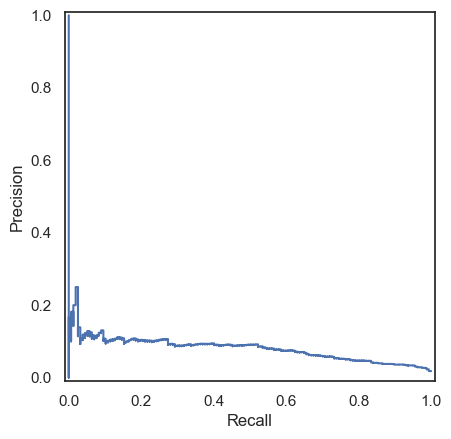

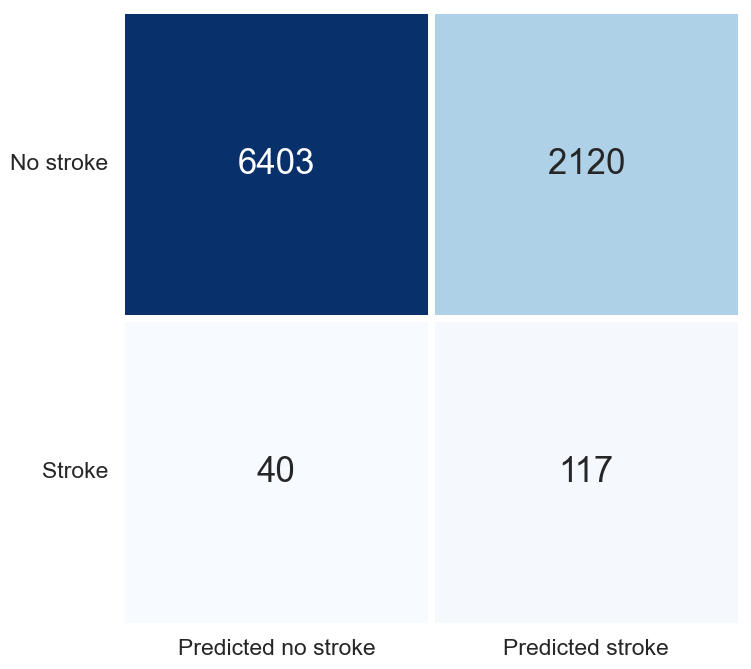

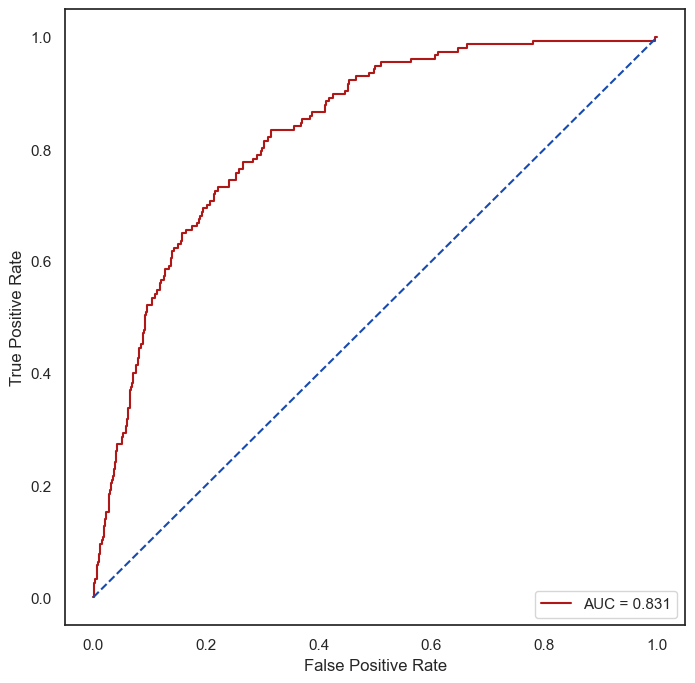

In [54]:
best_params = {'tol': 0.0009761035877691063, 'C': 0.010004064215669642}
best_params['random_state'] = 42
classifier = LogisticRegression(**best_params)
classifier.fit(X_train_res, y_train_res)

y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
auc_precision_recall = auc(rec, prec)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

print(f'Precisión media: {ap}')
print(f'Precisión-sensibilidad AUC: {auc_precision_recall}')
print('Exactitud balanceada: ', balanced_accuracy_score(y_test, y_pred))
print(f'ROC AUC: {roc_auc}')
print(f'Precisión: {precision}')
print(f'Sensibilidad: {recall}')
print(f'Puntuación F1: {f1}')
print(classification_report(y_test, y_pred))

disp = PrecisionRecallDisplay(precision=prec, recall=rec)
disp.plot()

plt.figure(figsize = (8, 8))
sns.set(font_scale=1.5)
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 25}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))),'utils', "image", "mat_LR.jpg"))

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "roc_LR.jpg"))

-- --

AdaBoostClassifier

In [63]:
def objective(trial):

    params = {
                'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
                'learning_rate' : trial.suggest_float('learning_rate', 0.1, 3.0),
    }    
    model = AdaBoostClassifier(**params)
    mean, std = custom_cross_val(model, X_train_res, y_train_res, synthetic_rows, cv=3)

    trial.set_user_attr('Standard deviation', std)
   
    return mean

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-04-18 15:36:06,999] A new study created in memory with name: no-name-3b7d4452-6497-472c-ad22-5fc34152a760
[I 2025-04-18 15:36:26,341] Trial 0 finished with value: 0.0709266899633189 and parameters: {'n_estimators': 95, 'learning_rate': 0.2767199723188341}. Best is trial 0 with value: 0.0709266899633189.
[I 2025-04-18 15:36:33,787] Trial 1 finished with value: 0.07344014018819361 and parameters: {'n_estimators': 26, 'learning_rate': 1.2464933702835992}. Best is trial 1 with value: 0.07344014018819361.
[I 2025-04-18 15:36:53,065] Trial 2 finished with value: 0.0649868312681186 and parameters: {'n_estimators': 56, 'learning_rate': 1.784004383719873}. Best is trial 1 with value: 0.07344014018819361.
[I 2025-04-18 15:37:16,093] Trial 3 finished with value: 0.04342186206936693 and parameters: {'n_estimators': 91, 'learning_rate': 2.8317074097924904}. Best is trial 1 with value: 0.07344014018819361.
[I 2025-04-18 15:37:34,721] Trial 4 finished with value: 0.06992951763784862 and param

In [64]:
best_params = study.best_params
best_score = round(study.best_value, 3)
deviation = round(study.best_trial.user_attrs['Standard deviation'], 3)

print(f'\033[1mAdaBoostClassifier Model\033[0m\nBest parameters: {best_params}\nBest Precision-recall score: {best_score}\nStandard deviation: {deviation}')

AdaBoostClassifier Model
Best parameters: {'n_estimators': 48, 'learning_rate': 1.6896044154838015}
Best Precision-recall score: 0.081
Standard deviation: 0.015


AdaBoostClassifier(learning_rate=1.6896044154838015, n_estimators=48)

Precisión media: 0.06983437031159741
Precisión-sensibilidad AUC: 0.06808570166894963
Exactitud balanceada:  0.7267035395419363
ROC AUC: 0.805262418439128
Precisión: 0.04741921947125472
Sensibilidad: 0.7197452229299363
Puntuación F1: 0.08897637795275591
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      8523
           1       0.05      0.72      0.09       157

    accuracy                           0.73      8680
   macro avg       0.52      0.73      0.47      8680
weighted avg       0.98      0.73      0.83      8680



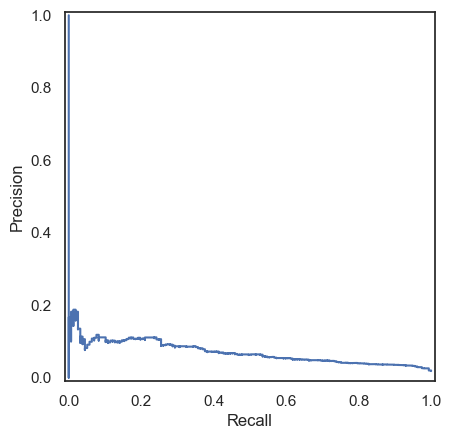

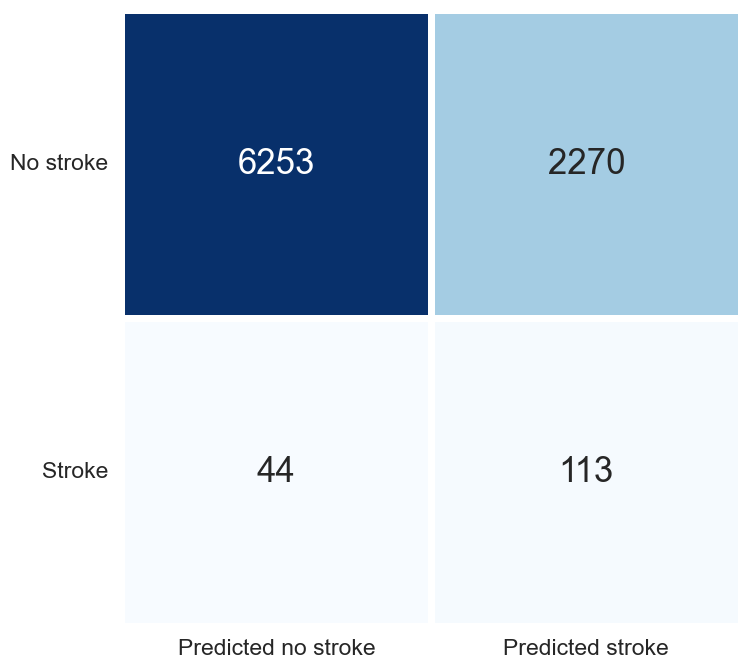

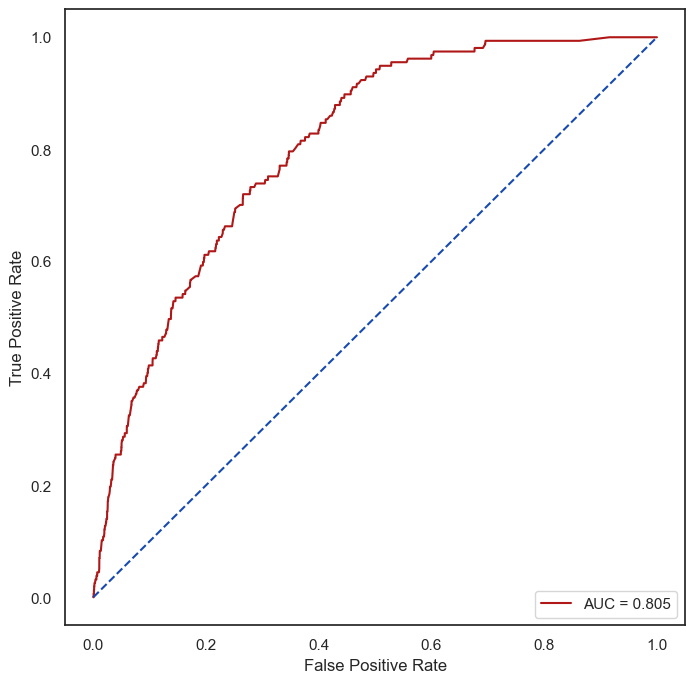

In [55]:
best_params = {'n_estimators': 48, 'learning_rate': 1.6896044154838015}
best_params['random_state'] = 42
classifier = AdaBoostClassifier(**best_params)
classifier.fit(X_train_res, y_train_res)

y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
auc_precision_recall = auc(rec, prec)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

print(f'Precisión media: {ap}')
print(f'Precisión-sensibilidad AUC: {auc_precision_recall}')
print('Exactitud balanceada: ', balanced_accuracy_score(y_test, y_pred))
print(f'ROC AUC: {roc_auc}')
print(f'Precisión: {precision}')
print(f'Sensibilidad: {recall}')
print(f'Puntuación F1: {f1}')
print(classification_report(y_test, y_pred))

disp = PrecisionRecallDisplay(precision=prec, recall=rec)
disp.plot()

plt.figure(figsize = (8, 8))
sns.set(font_scale=1.5)
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 25}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))),'utils', "image", "mat_ADA.jpg"))

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "roc_ADA.jpg"))

-- -- 

SVC

In [ ]:
def objective(trial):

    params = {
                'C' : trial.suggest_int('C', 1, 100),
                'gamma' : trial.suggest_float('gamma', 0.0001, 1),
                'kernel' : trial.suggest_categorical('kernel', ['linear', 'rbf','poly']),
                'degree' : trial.suggest_int('degree', 1, 6),
                'probability' : True,
    }
    model = SVC(**params)
    mean, std = custom_cross_val(model, X_train_res, y_train_res, synthetic_rows, cv=2)

    trial.set_user_attr('Standard deviation', std)
   
    return mean

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=-1)

[I 2025-04-19 02:05:13,473] A new study created in memory with name: no-name-93869dbb-0631-4686-9e13-ceb09adb3e08
[I 2025-04-19 03:21:30,138] Trial 2 finished with value: 0.083631505049508 and parameters: {'C': 2, 'gamma': 0.24448753223727226, 'kernel': 'linear', 'degree': 1}. Best is trial 2 with value: 0.083631505049508.
[I 2025-04-19 03:27:55,811] Trial 1 finished with value: 0.11893581086391022 and parameters: {'C': 47, 'gamma': 0.11926824683896037, 'kernel': 'rbf', 'degree': 3}. Best is trial 1 with value: 0.11893581086391022.
[I 2025-04-19 03:58:24,448] Trial 5 finished with value: 0.11377008353854719 and parameters: {'C': 92, 'gamma': 0.6971072065899394, 'kernel': 'rbf', 'degree': 1}. Best is trial 1 with value: 0.11893581086391022.
[I 2025-04-19 04:43:39,812] Trial 9 finished with value: 0.08363814076969385 and parameters: {'C': 2, 'gamma': 0.3700446528988134, 'kernel': 'poly', 'degree': 1}. Best is trial 1 with value: 0.11893581086391022.
[I 2025-04-19 05:44:05,932] Trial 0 fi

In [ ]:
best_params = study.best_params
best_score = round(study.best_value, 3)
deviation = round(study.best_trial.user_attrs['Standard deviation'], 3)

print(f'\033[1mSupport Vector Classifier Model\033[0m\nBest parameters: {best_params}\nBest Precision-recall score: {best_score}\nStandard deviation: {deviation}')

Precisión media: 0.03993799424988198
Precisión-sensibilidad AUC: 0.038673747259249186
Exactitud balanceada:  0.5961878349404496
ROC AUC: 0.7162881106275936
Precisión: 0.043220338983050846
Sensibilidad: 0.3248407643312102
Puntuación F1: 0.0762902019446522
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      8523
           1       0.04      0.32      0.08       157

    accuracy                           0.86      8680
   macro avg       0.51      0.60      0.50      8680
weighted avg       0.97      0.86      0.91      8680



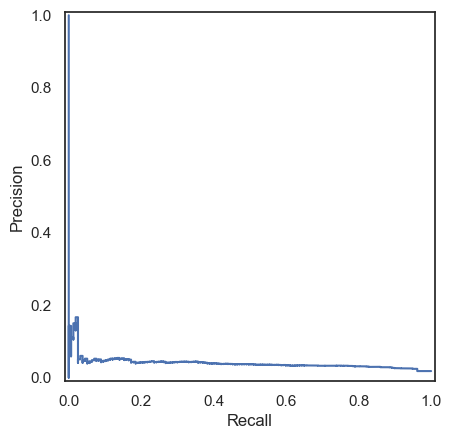

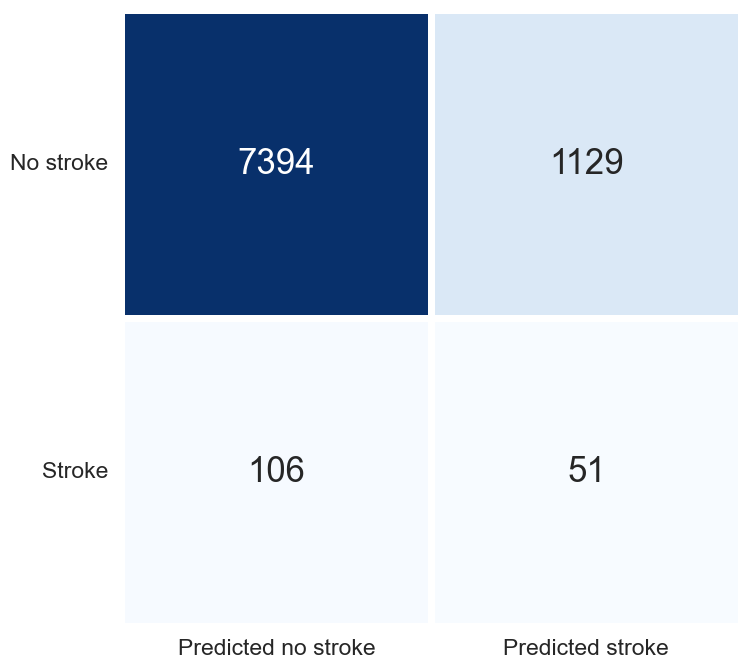

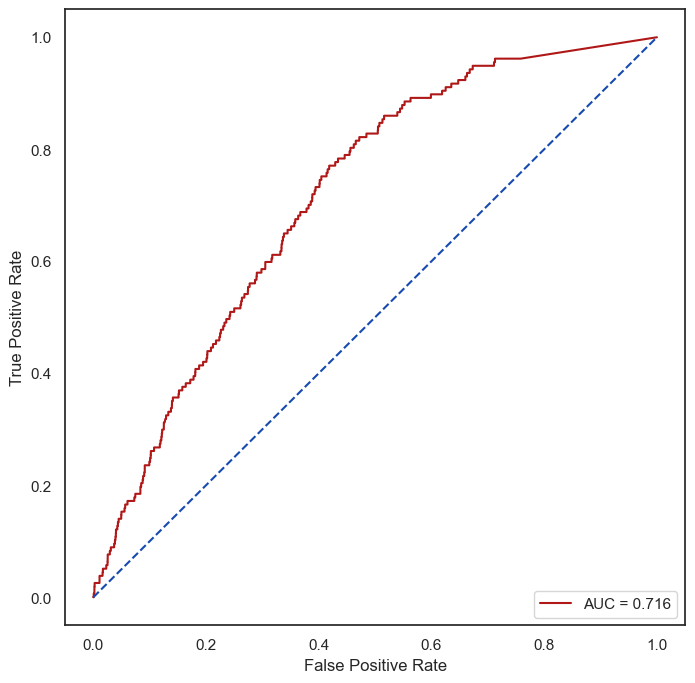

In [57]:
best_params = {'C': 41, 'gamma': 0.32722901349628547, 'kernel': 'rbf', 'degree': 2}
best_params['probability'], best_params['random_state'] = True, 42
classifier = SVC(**best_params)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
auc_precision_recall = auc(rec, prec)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

print(f'Precisión media: {ap}')
print(f'Precisión-sensibilidad AUC: {auc_precision_recall}')
print('Exactitud balanceada: ', balanced_accuracy_score(y_test, y_pred))
print(f'ROC AUC: {roc_auc}')
print(f'Precisión: {precision}')
print(f'Sensibilidad: {recall}')
print(f'Puntuación F1: {f1}')
print(classification_report(y_test, y_pred))

disp = PrecisionRecallDisplay(precision=prec, recall=rec)
disp.plot()

plt.figure(figsize = (8, 8))
sns.set(font_scale=1.5)
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 25}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))),'utils', "image", "mat_SVC.jpg"))

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "roc_SVC.jpg"))

-- --

RandomForest

In [55]:
def objective(trial):

    params = {
                'n_estimators' : trial.suggest_int('n_estimators', 10, 200, log=True),
                'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
                'max_depth' : trial.suggest_int('max_depth', 2, 32),
                'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
    }
    model = RandomForestClassifier(**params)
    mean, std = custom_cross_val(model, X_train_res, y_train_res, synthetic_rows, cv=3)

    trial.set_user_attr('Standard deviation', std)
   
    return mean

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-04-18 19:03:48,660] A new study created in memory with name: no-name-f8c72a33-cb69-438c-8d5f-14e51fc3c0b7
[I 2025-04-18 19:03:57,830] Trial 0 finished with value: 0.19409423664482897 and parameters: {'n_estimators': 30, 'criterion': 'log_loss', 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.19409423664482897.
[I 2025-04-18 19:04:03,060] Trial 1 finished with value: 0.2177320097783998 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.2177320097783998.
[I 2025-04-18 19:04:26,391] Trial 2 finished with value: 0.17924762437359598 and parameters: {'n_estimators': 110, 'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.2177320097783998.
[I 2025-04-18 19:04:35,127] Trial 3 finished with value: 0.16844851596687482 and parameters: {'n_estimators': 27, 'criterion': 'entropy',

In [56]:
best_params = study.best_params
best_score = round(study.best_value, 3)
deviation = round(study.best_trial.user_attrs['Standard deviation'], 3)

print(f'\033[1mRandom Forest Classifier Model\033[0m\nBest parameters: {best_params}\nBest Precision-recall score: {best_score}\nStandard deviation: {deviation}')

Random Forest Classifier Model
Best parameters: {'n_estimators': 160, 'criterion': 'log_loss', 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best Precision-recall score: 0.35
Standard deviation: 0.051


Precisión media: 0.04559935824668658
Precisión-sensibilidad AUC: 0.04487190906916304
Exactitud balanceada:  0.5533277882029218
ROC AUC: 0.7821029047664954
Precisión: 0.04381846635367762
Sensibilidad: 0.17834394904458598
Puntuación F1: 0.07035175879396985
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      8523
           1       0.04      0.18      0.07       157

    accuracy                           0.91      8680
   macro avg       0.51      0.55      0.51      8680
weighted avg       0.97      0.91      0.94      8680



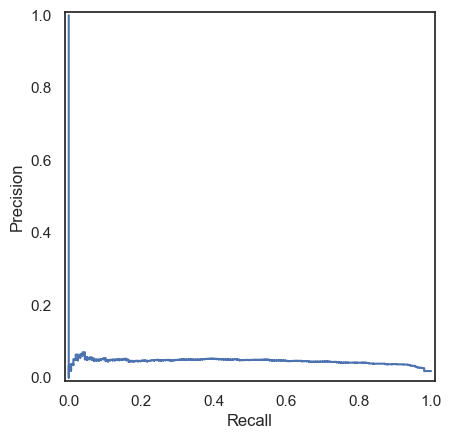

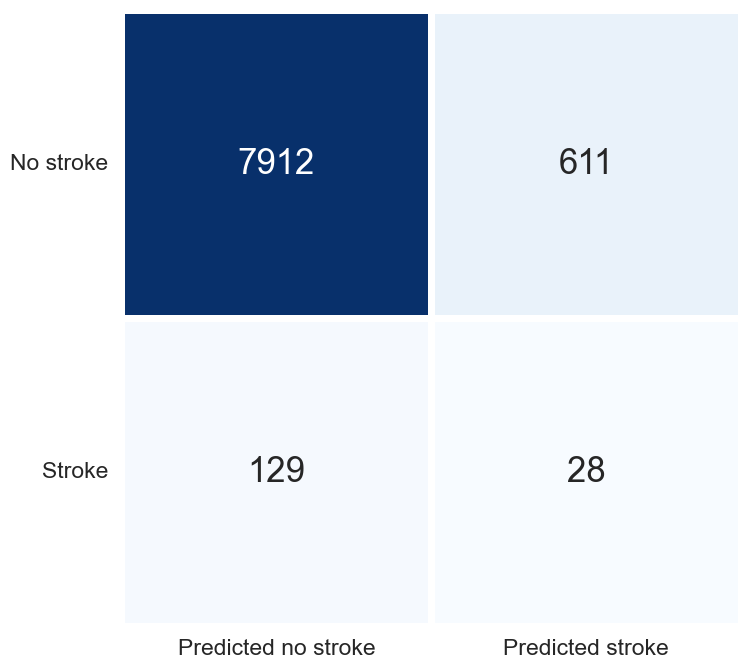

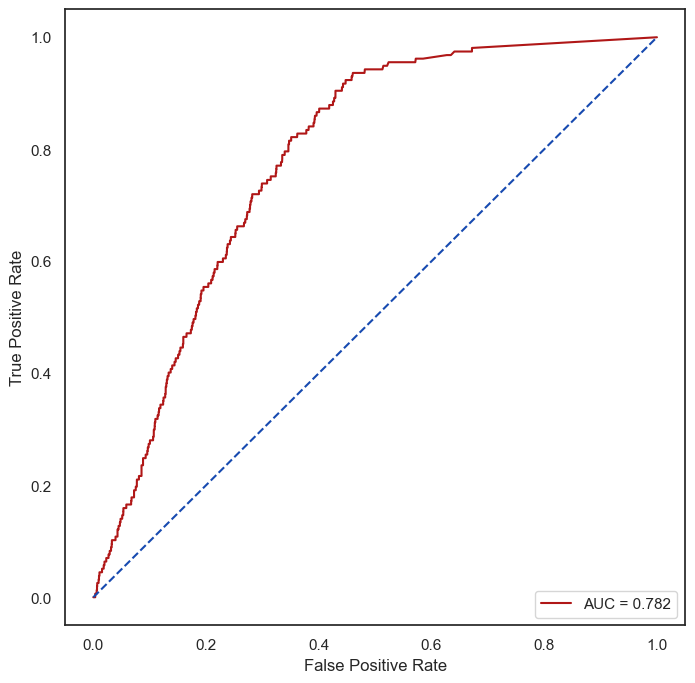

In [56]:
best_params = {'n_estimators': 160, 'criterion': 'log_loss', 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 1}
best_params['random_state'] = 42
classifier = RandomForestClassifier(**best_params)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
auc_precision_recall = auc(rec, prec)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

print(f'Precisión media: {ap}')
print(f'Precisión-sensibilidad AUC: {auc_precision_recall}')
print('Exactitud balanceada: ', balanced_accuracy_score(y_test, y_pred))
print(f'ROC AUC: {roc_auc}')
print(f'Precisión: {precision}')
print(f'Sensibilidad: {recall}')
print(f'Puntuación F1: {f1}')
print(classification_report(y_test, y_pred))

disp = PrecisionRecallDisplay(precision=prec, recall=rec)
disp.plot()

plt.figure(figsize = (8, 8))
sns.set(font_scale=1.5)
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 25}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))),'utils', "image", "mat_RFC.jpg"))

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))), 'utils', "image", "roc_RFC.jpg"))

-- --

### Guardamos modelo escogido

In [536]:
X = pd.concat([X_train_res.reset_index(drop=True), X_test.reset_index(drop=True)], axis=0).reset_index(drop=True)
y = pd.concat([y_train_res.reset_index(drop=True), y_test.reset_index(drop=True)], axis=0).reset_index(drop=True)

In [537]:
best_model = LogisticRegression(**{'tol': 0.0009761035877691063, 'C': 0.010004064215669642})
best_model.fit(X, y)

LogisticRegression(C=0.010004064215669642, tol=0.0009761035877691063)

In [334]:
name = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('file'))),'model', 'modelo')
with open(name, 'wb') as file:  
    pickle.dump(best_model, file)